# Hash tests

The goal of this work if to measure the timing and number of collisions of different hashing algorithms available in Python's hashlib package. I got the passwords file from a friend at college.

In [1]:
%matplotlib inline

import hashlib
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

## The database

The database is composed of 300k users and passwords. I got it from a friend from college. Apparently, this whole thing I'm doing is a project from one of their courses...

Anyway, everything is stored in the file _data.csv_ that we'll load into a pandas DataFrame.

In [87]:
database_file = 'data.csv'
database = pd.read_csv(database_file)
database.head()

,Name,Cipher,Password
0,Adeline Abujanra,HWKVOLB,VKYJCZP
1,Adeline Abujanra Albuquerque,MHVDPTXGB,AVJRDHLUP
2,Adeline Abujanra Bandit,GEVQLYB,USJEZMP
3,Adeline Abujanra Barbosa,WSMJSXFE,KGAXGLTS
4,Adeline Abujanra Branco,HSZCLTBGG,VGNQZHPUU


Passwords are originally stored as Caesar ciphers shifted by 12 characters, so in case they are still ciphered, we'll create a new column with the unciphered passwords and save it to the database file so we'll never have to do it again.

In [4]:
def caesar(plainText, shift):
    """Caesar Cipher implementation.
       Upper and lower case letters are kept accordingly, non-alphabetic characters are ignored.
       Implementation taken from here: https://stackoverflow.com/q/8886947/1245214
       
       :param plainText: the text to be ciphered
       :param shift: shift value for the cipher
       :return: the ciphered text
    """
    cipherText = ""
    
    for ch in plainText:
        finalLetter = ch
        if ch.isalpha():
            finalLetter = chr((ord(ch.lower()) - 97 + shift) % 26 + 97)        
        if ch.isupper():
            finalLetter = finalLetter.upper()

        cipherText += finalLetter

    return cipherText

if 'Password' not in database.columns:
    database['Password'] = [caesar(x[1][1], -12) for x in tqdm(database.iterrows(), total=database.shape[0])]
    database.to_csv(database_file, index=None)

As you can see below, one of the passwords repeats for two different users. We'll keep it like that.

In [19]:
database['Password'].describe()

count       300000
unique      299999
top        URZRPUC
freq             2
Name: Password, dtype: object

Here we'll declare a DataFrame where our calculated hashes we'll be saved for further studies. Also, we put all hash functions in a list and give them user-friendly names.

In [5]:
# we'll save hashes into a file the first time they are produced...
hashes_file = 'hashes.csv'
hashes = pd.DataFrame()

times = []

# Which algorithms we are going to test
experiments = [('BLAKE2B', hashlib.blake2b),
               ('BLAKE2S', hashlib.blake2s),
               ('MD5', hashlib.md5),
               ('SHA1', hashlib.sha1),
               ('SHA224', hashlib.sha224),
               ('SHA256', hashlib.sha256),
               ('SHA384', hashlib.sha384),
               ('SHA512', hashlib.sha512),
               ('SHA3-224', hashlib.sha3_224),
               ('SHA3-256', hashlib.sha3_256),
               ('SHA3-384', hashlib.sha3_384),
               ('SHA3-512', hashlib.sha3_512)]

# How many times we are going to hash all passwords in the database, with each algorithm
num_experiments = 30

Here we run our experiments. The database has 300k passwords, and we are going to hash all of them `num_experiments` times, for each algorithm listed in `experiments`.

In [7]:
# For each algorithm...
for algo_name, alfo_function in experiments:    
    for i in range(num_experiments):
        
        time = 0
        hashes_list = []
        for index, row in tqdm(database.iterrows(),
                               desc=algo_name + ' (' + str(i + 1) + '/' + str(num_experiments) + ')',
                               total=database.shape[0]):
            
            # small fact: when loading a file into a pandas DataFrame, you can actually  tell
            # what's the encoding of the file:

            # >>>> database = pd.read_csv(database_file)

            # But since here we are iterating over rows,
            # we have to explicitly encode our strings AGAIN before hashing them,
            # so I don't even bother telling pandas the file encoding in the first place...
            username = row[0].encode('utf-8')
            password = row[2].encode('utf-8')
            
            # create our hashing object
            m = alfo_function()
            m.update(password)
            
            # we only time this part of the code
            # ==================================
            start = time.time()
            hashe = str(m.hexdigest())
            end = time.time()
            # ==================================
            
            time += end - start
            
            if algo_name not in hashes.columns:
                hashes_list.append(hashe)

        # results are appended to a list
        times.append((algo_name, time))
        
        # We are going to save the hashes to our database, in case they don't still exist
        if algo_name not in hashes.columns:
            hashes[algo_name] = hashes_list
            hashes.to_csv(hashes_file, index=None)

SHA3-512 (30/30): 100%|██████████| 300000/300000 [00:15<00:00, 19265.70it/s]


## The results

Here is a summary of the times achieved by each algorithm. Remember that we are alloking at the time it took to hash _all passwords_ in the database.

All algorithms took between 0.22 and 0.34 milliseconds to hash the entire database.

In [9]:
df = pd.DataFrame(data=times, columns=['Algorithm', 'Time (s)'])
df.to_csv('times.csv')
df.groupby('Algorithm').describe()

Time (s)                                                    \
             count      mean       std       min       25%       50%   
Algorithm                                                              
BLAKE2B       30.0  0.248487  0.002127  0.240787  0.247550  0.248706   
BLAKE2S       30.0  0.228173  0.003643  0.223792  0.225996  0.227166   
MD5           30.0  0.237197  0.004512  0.230367  0.232829  0.238192   
SHA1          30.0  0.250656  0.003196  0.239348  0.249149  0.250661   
SHA224        30.0  0.287874  0.004235  0.278916  0.285843  0.286895   
SHA256        30.0  0.276745  0.003878  0.267915  0.273723  0.277144   
SHA3-224      30.0  0.319605  0.002387  0.313913  0.318221  0.319802   
SHA3-256      30.0  0.307538  0.005716  0.300043  0.304267  0.306089   
SHA3-384      30.0  0.313299  0.003651  0.305241  0.311151  0.313547   
SHA3-512      30.0  0.311212  0.006965  0.297955  0.307226  0.310301   
SHA384        30.0  0.302172  0.003103  0.295251  0.300665  0.301837   
SHA512        30.0  0.306968  0.003514  0.297986  0.305467  0.306798   

                               
                75%       max  
Algorithm                      
BLAKE2B    0.249917  0.251434  
BLAKE2S    0.228604  0.239910  
MD5        0.240946  0.244690  
SHA1       0.252383  0.258050  
SHA224     0.288692  0.303106  
SHA256     0.279836  0.282058  
SHA3-224   0.321015  0.324430  
SHA3-256   0.308821  0.323905  
SHA3-384   0.316470  0.318344  
SHA3-512   0.314477  0.337991  
SHA384     0.303359  0.310192  
SHA512     0.307959  0.316255

The boxplot allows us to unveil some more cool info. We can see that BLAKE2b, BLAKE2S, MD5 and SHA-1 are the fastest ones. According to Wikipedia, [BLAKE2b is supposed to be the fastest one of all](https://en.wikipedia.org/wiki/BLAKE_(hash_function)) on x64 machines, but BLAKE2s got the podium, probably because it computes smaller digests than BLAKE2b.

We can also see that most of the more secure hashing functions (from SHA-384 to SHA3-512) have comparable time, between 0.3 and 0.32 seconds. But, since their boxes don't overlap, we can't really say they operate in equal time.

That is also the case for the SHA-2 family of algorithms (from SHA-224 To SHA-512). They all got very different hashing times.

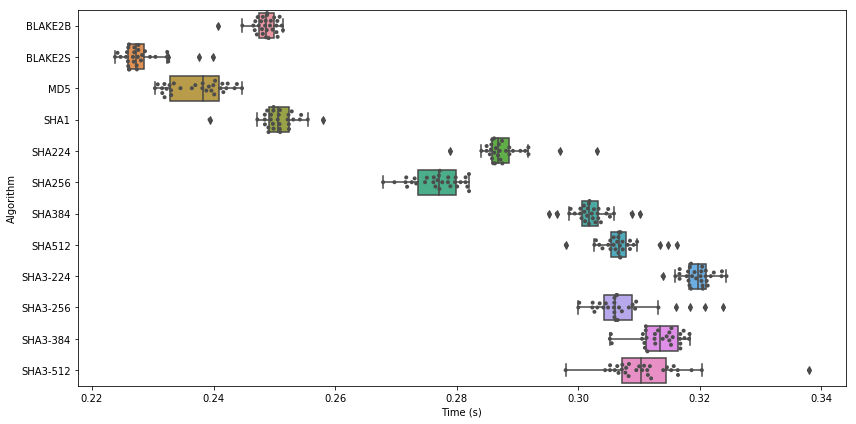

In [10]:
df = pd.read_csv('times.csv')
fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(ax=ax, data=df, x='Time (s)', y='Algorithm')
sns.swarmplot(ax=ax, x="Time (s)", y="Algorithm", data=df,
              size=4, color=".3", linewidth=0)
fig.tight_layout()

Here we check for collisions. For all hashing functions, there appears to be a single collision, but since we saw before that there is a single password that repeats in the database, this outcome is to be expected.

In short, there were no collisions.

In [36]:
hashes.describe()

,BLAKE2B,BLAKE2S,MD5,SHA1,SHA224,SHA256,SHA384,SHA512,SHA3-224,SHA3-256,SHA3-384,SHA3-512
count,300000,300000,300000,300000,300000,300000,300000,300000,300000,300000,300000,300000
unique,299999,299999,299999,299999,299999,299999,299999,299999,299999,299999,299999,299999
top,36a175ae8b00b3a427b942bc3ae8e62bb0f91cb543beb8...,2d3325a987fef6b7634a446e6fd76bf07777f47dbc7885...,721b6d41e08a9f3e99d9e2eb4dc1bfcf,b0d8d5a9b2bf38f9e863ce46bc63ea8b2dbb0f7a,444112182840b69e35b5faba9cf9a1563f0a6ea4675a68...,c04e3dd5c99b760569058c6e65d78380535d257847fe9d...,0c938de552e61e8afbb8fa6b7043bad0a7c737e7776c1a...,32dd9701b274051e03a408dbdded84496e3f366f409ff6...,dd0297d931d1bb6abffbb26575bd3977556b5665d7d885...,ae0b3626d91eb72a5132644097acc41d253a8f5f5ca698...,5f2828e10a2e5c8f5d0d3ff68e9d2e630b0b573f3ade0d...,b1ed3ff23768245ece6ce1db34bc6bd65177fc72ff26a8...
freq,2,2,2,2,2,2,2,2,2,2,2,2


Now let's take a look at the length of the digests (the output of the hash functions). As expected, all functions output a string with equal length, everytime they are applied.

In [85]:
hash_lengths = pd.DataFrame(columns=hashes.columns)
for algo_name in hashes.columns:
    hash_lengths[algo_name] = hashes[algo_name].apply(len)

hash_lengths.describe().loc[['mean', 'std']]

,BLAKE2B,BLAKE2S,MD5,SHA1,SHA224,SHA256,SHA384,SHA512,SHA3-224,SHA3-256,SHA3-384,SHA3-512
mean,128.0,64.0,32.0,40.0,56.0,64.0,96.0,128.0,56.0,64.0,96.0,128.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here, I plot the hash time of each function as a function of their digest size. By looking at the picture, can't really tell that the length of the digest is responsible for the majority of the processing time of each hash function.

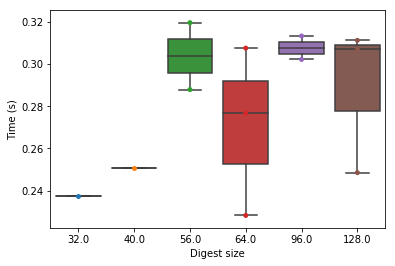

In [74]:
line = pd.DataFrame(data=df.groupby('Algorithm').mean()['Time (s)'])
line['Digest size'] = hash_lengths.mean()

g = sns.boxplot(x="Digest size", y="Time (s)", data=line)
g = sns.swarmplot(x="Digest size", y="Time (s)", data=line)